In [10]:
import wandb
from tqdm.auto import tqdm
import numpy as np

from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
import monai.transforms
from monai.utils import set_determinism

import torch
print_config()

MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /Users/<username>/anaconda3/envs/mri/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSI

In [11]:
import os
os.environ['WANDB_API_KEY'] = 'aa5821234bd41893b5da6713a5d8f3da4815ce68'

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [12]:
wandb.init(project="monai-brain-tumor-segmentation")

In [13]:
config = wandb.config
config.seed = 0
config.roi_size = [224, 224, 144]
config.batch_size = 1
config.num_workers = 4
config.max_train_images_visualized = 3
config.max_val_images_visualized = 3
config.dice_loss_smoothen_numerator = 0
config.dice_loss_smoothen_denominator = 1e-5
config.dice_loss_squared_prediction = True
config.dice_loss_target_onehot = False
config.dice_loss_apply_sigmoid = True
config.initial_learning_rate = 1e-4
config.weight_decay = 1e-5
config.max_train_epochs = 50
config.validation_intervals = 1
config.dataset_dir = "./dataset/"
config.checkpoint_dir = "./checkpoints"
config.inference_roi_size = (128, 128, 64)
config.max_prediction_images_visualized = 20

In [14]:
from typing import Optional, List
import monai
import monai.transforms
import SimpleITK as sitk
import numpy as np 
import torch
from lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms
import json
import os
import rootutils

rootutils.setup_root(search_from="/Users/tiendzung/Project/spine-segmentation/notebooks/logger_wandb.ipynb", indicator="setup.py", pythonpath=True)
from src.data.transforms import array

# always starting with vanilla dataset, like its a norm to me now
class SpiderDataset(Dataset):
    num_class = 15
    def __init__(self, 
                 data = None,
                 data_dir: str = "", 
                 json_path: str = "",
                 ):
        super().__init__()
        self.data = list()
        self.data_dir = data_dir
        if data is not None:
            self.data = data
        else:
            if data_dir == "" or json_path == "":
                raise AssertionError("No dataset ?")
            self.setup(json_path)
    
    def setup(self, json_path):
        json_object = json.load(open(json_path, "r"))
        keys = json_object.keys()
        if "training" in keys:
            for key in keys:
                self.data.extend(json_object[key])
        else:
            try:
                self.data.extend(json_object)
            except:
                raise InsertionError("Something wrong with json file, cannot load or do anything, at all")
    
    def get_item(self, index: int):
        output = dict()
        output["image"] = ""
        output["label"] = ""
        if isinstance(self.data[index]["image"], list):
            output["image"] = [os.path.join(self.data_dir, image) for image in self.data[index]["image"]]
        else:
            # Add for debugging
            path = os.path.join(self.data_dir, self.data[index]["image"])
            output["image"] = path ##Set to 4 because the model_inferr in validation_step
        output["label"] = os.path.join(self.data_dir, self.data[index]["label"])
        return output
    
    # In case they query in list of index
    def __getitem__(self, index):
        output = None
        if not isinstance(index, int):
            output = []
            for id in index:
                output.append(self.get_item(id))
        else:
            output = self.get_item(int(index))
        
        return output
    
    def __len__(self) -> int:
        return len(self.data)
    
    

class SpiderTransformedDataset(Dataset):
    def __init__(self, 
                 dataset: SpiderDataset,
                 transform: monai.transforms.Compose):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, index):
        output = None
        
        if not isinstance(index, int):
            output = []
            for id in index:
                output.append(self.transform(self.dataset[id]))
        else:
            output = self.transform(self.dataset[int(index)])

        return output
    
    def __len__(self) -> int:
        return len(self.dataset)

In [15]:
dataset = SpiderDataset(data_dir = "/Users/tiendzung/Project/spine-segmentation/data/dataset/spine_nii", json_path="/Users/tiendzung/Project/spine-segmentation/data/jsons/spine_infer.json")
# dataset = SpiderDataset(data_dir = "./data/dataset", json_path="/data/hpc/spine/jsons/brats21_folds.json")

transform = monai.transforms.Compose([monai.transforms.LoadImaged(keys=["image", "label"], image_only = False),
                                        array.ConvertToMultiChannelBasedOnSpiderClassesdSemantic(keys=["label"]),
                                        monai.transforms.EnsureChannelFirstd(keys=["image"]),
                                        monai.transforms.Spacingd(
                                            keys=["image", "label"],
                                            pixdim=(1.0, 1.0, 1.0),
                                            mode=("bilinear", "nearest"),
                                        ),
                                    #   monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
                                        # monai.transforms.Resized(keys=["image", "label"], spatial_size=(32, 420, 420)),
                                        monai.transforms.ToTensord(keys=["image", "label"]),])

transformed = SpiderTransformedDataset(dataset, transform)
id = 0
data = dataset[id]
images = transformed[id]
print(data)
print(images["image"].size(), images["image"].dtype)
print(images["label"].size(), images["label"].dtype)
print(images.keys())
print("------------------")
print(images['image_meta_dict'])
print("------------------")
print(images['label_meta_dict'])
print(images["label"].size())

# res = 0
# for image in transformed:
#     res = max(res, image["label"].size(0))

# print(res)
# [[  -3.3211,    0.0000,    0.0000,   66.6507],
#         [   0.0000,   -0.6250,    0.0000,   85.9260],
#         [   0.0000,    0.0000,    0.5006, -119.7997],
#         [   0.0000,    0.0000,    0.0000,    1.0000]]

{'image': '/Users/tiendzung/Project/spine-segmentation/data/dataset/spine_nii/images/77_t1.nii.gz', 'label': '/Users/tiendzung/Project/spine-segmentation/data/dataset/spine_nii/masks/77_t1.nii.gz'}
torch.Size([1, 71, 280, 280]) torch.float32
torch.Size([3, 71, 280, 280]) torch.float32
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
------------------
{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3,  17, 384, 384,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(4, dtype=int16), 'bitpix': array(16, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1.       , 4.4      , 0.7291667, 0.7291667, 0.       , 0.       ,
       0.       , 0.       ], dtype=float32), 'vox_offset': arra

## Log wandb

In [18]:
def log_data_samples_into_tables(
    sample_image: np.array,
    sample_label: np.array,
    split: str = None,
    data_idx: int = None,
    table: wandb.Table = None,
):
    print(sample_image.shape)
    num_channels, num_slices, _, _ = sample_image.shape
    with tqdm(total=num_slices, leave=False) as progress_bar:
        for slice_idx in range(num_slices):
            ground_truth_wandb_images = []
            for channel_idx in range(num_channels):
                ground_truth_wandb_images.append(
                    wandb.Image(
                        sample_image[channel_idx, slice_idx, :, :],
                        masks={
                            "Pred: Vertebral": {    
                                "mask_data": sample_label[0, slice_idx, :, :],
                                "class_labels": {1: "Pred: Vertebral"},
                            },
                            "GT: Vertebral": {    
                                "mask_data": sample_label[0, slice_idx, :, :] * 2,
                                "class_labels": {2: "GT: Vertebral"},
                            },

                            "Pred: Canal": {
                                "mask_data": sample_label[1, slice_idx, :, :] * 3,
                                "class_labels": {3: "Pred: Canal"},
                            },
                            "GT: Canal": {
                                "mask_data": sample_label[1, slice_idx, :, :] * 4,
                                "class_labels": {4: "GT: Canal"},
                            },
                            
                            "Pred: Disk": {
                                "mask_data": sample_label[2, slice_idx, :, :] * 5,
                                "class_labels": {5: "Pred: Disk"},
                            },
                            "GT: Disk": {
                                "mask_data": sample_label[2, slice_idx, :, :] * 6,
                                "class_labels": {6: "GT: Disk"},
                            },
                        },
                    )
                )
            table.add_data(split, data_idx, slice_idx, *ground_truth_wandb_images)
            progress_bar.update(1)
    return table


table = wandb.Table(
    columns=[
        "Split",
        "Data Index",
        "Slice Index",
        "Image-Channel"
    ]
)

In [19]:
# Generate visualizations for train_dataset
max_samples = (
    min(config.max_train_images_visualized, len(transformed))
    if config.max_train_images_visualized > 0
    else len(transformed)
)
progress_bar = tqdm(
    enumerate(transformed.__getitem__([0, 1, 2])),
    total=max_samples,
    desc="Generating Train Dataset Visualizations:",
)
for data_idx, sample in progress_bar:
    sample_image = sample["image"].detach().cpu().numpy()
    sample_label = sample["label"].detach().cpu().numpy()
    table = log_data_samples_into_tables(
        sample_image,
        sample_label,
        split="train",
        data_idx=data_idx,
        table=table,
    )

# # Generate visualizations for val_dataset
# max_samples = (
#     min(config.max_val_images_visualized, len(val_dataset))
#     if config.max_val_images_visualized > 0
#     else len(val_dataset)
# )
# progress_bar = tqdm(
#     enumerate(val_dataset[:max_samples]),
#     total=max_samples,
#     desc="Generating Validation Dataset Visualizations:",
# )
# for data_idx, sample in progress_bar:
#     sample_image = sample["image"].detach().cpu().numpy()
#     sample_label = sample["label"].detach().cpu().numpy()
#     table = log_data_samples_into_tables(
#         sample_image,
#         sample_label,
#         split="val",
#         data_idx=data_idx,
#         table=table,
#     )

# Log the table to your dashboard
wandb.log({"Tumor-Segmentation-Data": table})
     

Generating Train Dataset Visualizations::   0%|          | 0/3 [00:00<?, ?it/s]

(1, 71, 280, 280)


Generating Train Dataset Visualizations::  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

(1, 300, 300, 54)


Generating Train Dataset Visualizations::  67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

(1, 300, 300, 54)


Generating Train Dataset Visualizations:: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


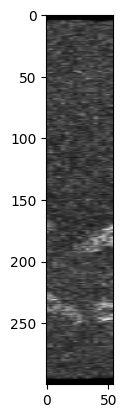

In [11]:
import matplotlib.pyplot as plt

plt.imshow(transformed[1]["image"][0, 25, :, :], cmap="gray")

In [8]:
bruh = monai.transforms.Compose([monai.transforms.LoadImage(image_only = False),
                                        # array.ConvertToMultiChannelBasedOnSpiderClassesdSemantic(keys=["label"]),
                                        # Spacing(
                                        # keys=["image", "label"],
                                        # pixdim=(1.0, 1.0, 1.0),
                                        # mode=("bilinear", "nearest"),
                                    # ),
                                    #   monai.transforms.Resize(keys=["image", "label"], spatial_size=(250, 250, 155)),
                                        monai.transforms.ToTensor(),])


print(bruh('/Users/tiendzung/Downloads/BraTS2021_00630/BraTS2021_00630_t2.nii.gz'))

RuntimeError: applying transform <monai.transforms.io.array.LoadImage object at 0x7f13c567ba60>

In [11]:
import nibabel as nib
import matplotlib.pyplot as plt

seg_out = np.zeros((100,200,3))

nib.save(nib.Nifti1Image(seg_out.astype(np.uint8), affine=None), "/Users/tiendzung/Project/spine-segmentation/notebooks/test.nii.gz")

In [12]:
img = nib.load("/Users/tiendzung/Downloads/spine_nii/masks/105_t1.nii.gz")
header = img.header
print(img.header)
print(header.get_data_shape())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  25 448 427   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         3.293679   0.625      0.65749806 0.         0.
 0.         0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 40.683353
qoffset_y       : 91.359055
qoffset_z

In [13]:
print(img.affine)

[[ -3.293679     0.           0.          40.68335342]
 [  0.          -0.625        0.          91.35905457]
 [  0.           0.           0.65749806 -93.87355804]
 [  0.           0.           0.           1.        ]]


In [14]:
image_data = img.get_fdata()
print(image_data.shape)

(25, 448, 427)


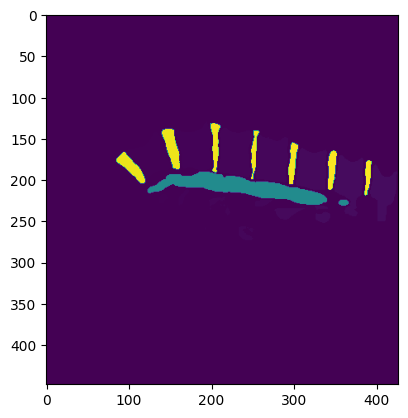

In [15]:
plt.imshow(image_data[10, :, :],)

In [70]:
affine = img.affine

affine[0, 0] = affine[0, 0] * -1
affine[1, 1] = affine[1, 1] * -1

print(affine)

nib.save(nib.Nifti1Image(image_data.astype(np.uint8), affine=affine), "/Users/tiendzung/Project/spine-segmentation/notebooks/test.nii.gz")

[[  3.293679     0.           0.          40.68335342]
 [  0.           0.625        0.          91.35905457]
 [  0.           0.           0.65749806 -93.87355804]
 [  0.           0.           0.           1.        ]]


In [17]:
test = nib.load("/Users/tiendzung/Downloads/BraTS2021_00630/BraTS2021_00630_t2.nii.gz")
print(test.header)
print(test.header.get_data_shape())

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1. -0. -0.  0.]
srow_y          : 

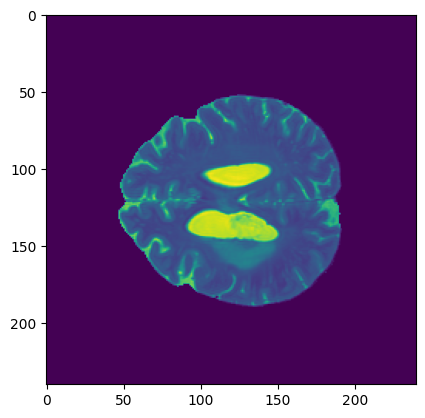

In [20]:
brats_img = test.get_fdata()

plt.imshow(brats_img[:, :, 100])

## Merge mask

In [3]:
from matplotlib import pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


In [4]:
print(images["label"].size())
print(images["label"][0])

bruh = torch.sum(images["label"], dim=3)
print(bruh.size())


torch.Size([3, 82, 141, 145])
metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0

torch.Size([141, 145])
(141, 145)


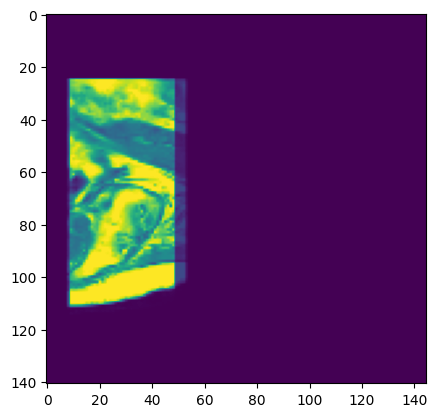

In [5]:
from matplotlib import pyplot as plt
from PIL import Image
print(images["label"][0][12].shape)
print(np.array(images["label"][0][12]).shape)


# plt.imshow(Image.fromarray(np.array(images["image"][0][12])))
plt.imshow(np.rot90(np.array(images["image"][0][12]), 1))
plt.imshow(images["image"][0][12])

Coronal View shape: (3, 145, 23)
Sagittal View shape: torch.Size([3, 141, 145])
<class 'numpy.ndarray'>


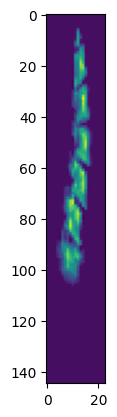

In [9]:
from scipy.ndimage import zoom
from matplotlib import cm
import cv2


coronal_view = zoom(torch.sum(images["label"], dim=2).permute(0, 2, 1), (1, 1, images["label"].shape[2]/images["label"].shape[1]/6))
coronal_view = coronal_view[:,::-1,:]
sagittal_view = torch.sum(images["label"], dim=1)

print(f"Coronal View shape: {coronal_view.shape}")
print(f"Sagittal View shape: {sagittal_view.shape}")
plt.imshow(coronal_view[0])

/work/hpc/miniconda3/envs/mri/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


/work/hpc/spine-segmentation/notebooks


Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC77_t1.nii.gz
Inference on case 77_t1.nii.gz
(384, 64, 3)
(384, 384, 3)


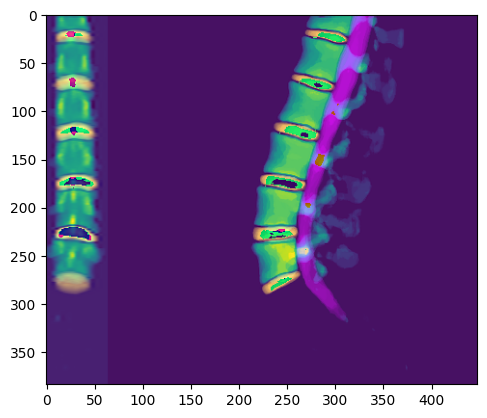

(3, 17, 384, 384)
Bruhhhh
(3, 17, 384, 384)
(17, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC78_t1.nii.gz
Inference on case 78_t1.nii.gz
(512, 85, 3)
(512, 512, 3)


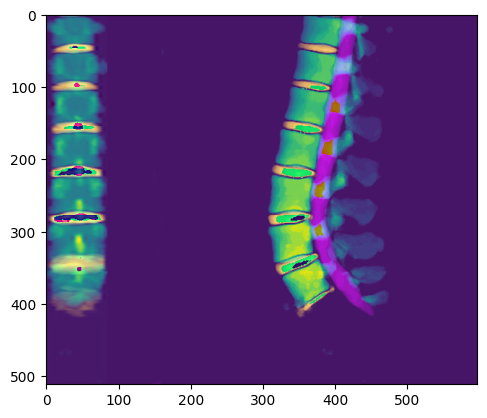

(3, 17, 512, 512)
Bruhhhh
(3, 17, 512, 512)
(17, 512, 512)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC78_t2.nii.gz
Inference on case 78_t2.nii.gz
(512, 85, 3)
(512, 512, 3)


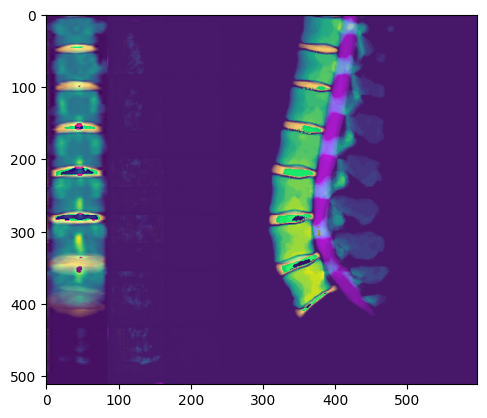

(3, 17, 512, 512)
Bruhhhh
(3, 17, 512, 512)
(17, 512, 512)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC78_t2_SPACE.nii.gz
Inference on case 78_t2_SPACE.nii.gz
(640, 85, 3)
(640, 512, 3)


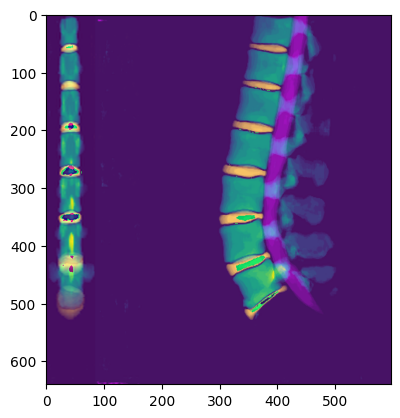

(3, 120, 512, 640)
Bruhhhh
(3, 120, 512, 640)
(120, 512, 640)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC8_t1.nii.gz
Inference on case 8_t1.nii.gz
(384, 64, 3)
(384, 384, 3)


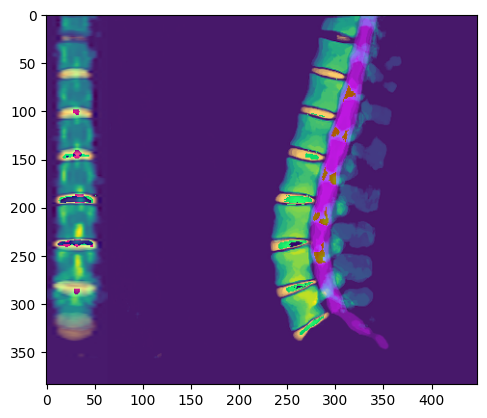

(3, 15, 384, 384)
Bruhhhh
(3, 15, 384, 384)
(15, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC8_t2.nii.gz
Inference on case 8_t2.nii.gz
(384, 64, 3)
(384, 384, 3)


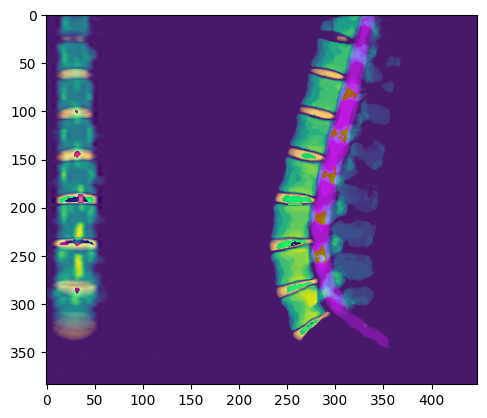

(3, 15, 384, 384)
Bruhhhh
(3, 15, 384, 384)
(15, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC80_t1.nii.gz
Inference on case 80_t1.nii.gz
(413, 75, 3)
(413, 448, 3)


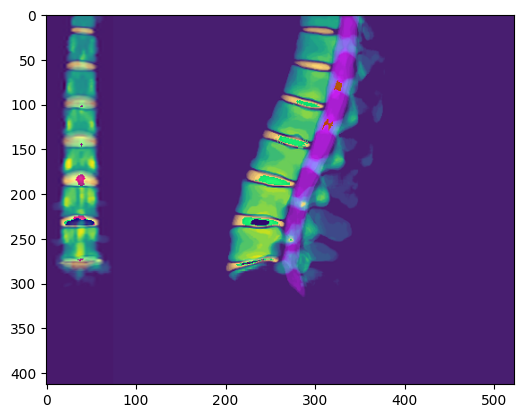

(3, 26, 448, 413)
Bruhhhh
(3, 26, 448, 413)
(26, 448, 413)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC80_t2.nii.gz
Inference on case 80_t2.nii.gz
(413, 75, 3)
(413, 448, 3)


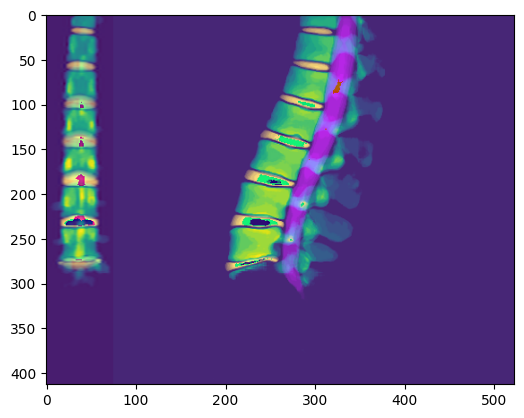

(3, 26, 448, 413)
Bruhhhh
(3, 26, 448, 413)
(26, 448, 413)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC81_t1.nii.gz
Inference on case 81_t1.nii.gz
(649, 85, 3)
(649, 512, 3)


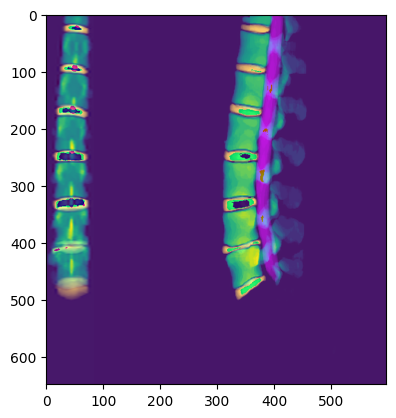

(3, 20, 512, 649)
Bruhhhh
(3, 20, 512, 649)
(20, 512, 649)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC81_t2.nii.gz
Inference on case 81_t2.nii.gz
(649, 85, 3)
(649, 512, 3)


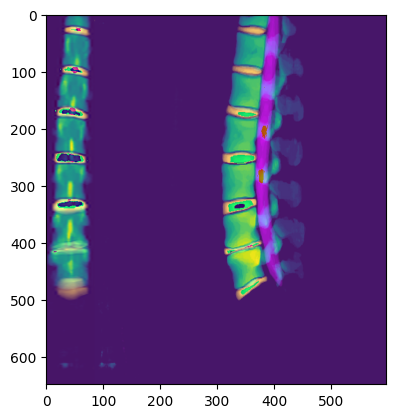

(3, 20, 512, 649)
Bruhhhh
(3, 20, 512, 649)
(20, 512, 649)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC81_t2_SPACE.nii.gz
Inference on case 81_t2_SPACE.nii.gz
(697, 85, 3)
(697, 512, 3)


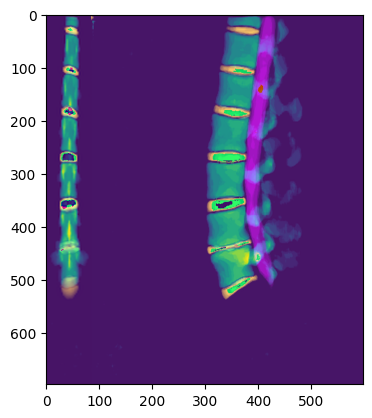

(3, 130, 512, 697)
Bruhhhh
(3, 130, 512, 697)
(130, 512, 697)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC82_t1.nii.gz
Inference on case 82_t1.nii.gz
(320, 53, 3)
(320, 320, 3)


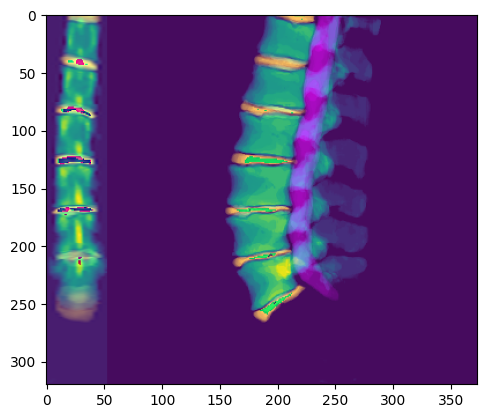

(3, 17, 320, 320)
Bruhhhh
(3, 17, 320, 320)
(17, 320, 320)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC82_t2.nii.gz
Inference on case 82_t2.nii.gz
(384, 64, 3)
(384, 384, 3)


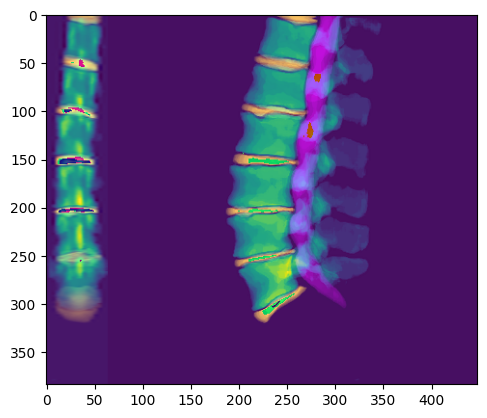

(3, 17, 384, 384)
Bruhhhh
(3, 17, 384, 384)
(17, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC83_t1.nii.gz
Inference on case 83_t1.nii.gz
(367, 102, 3)
(367, 615, 3)


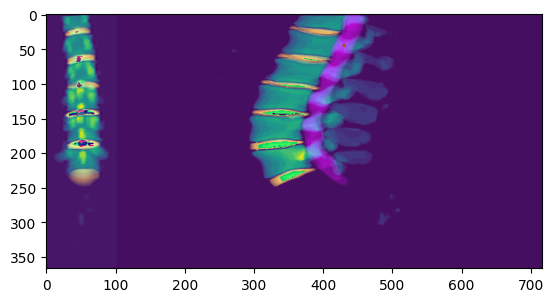

(3, 32, 615, 367)
Bruhhhh
(3, 32, 615, 367)
(32, 615, 367)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC83_t2.nii.gz
Inference on case 83_t2.nii.gz
(367, 102, 3)
(367, 615, 3)


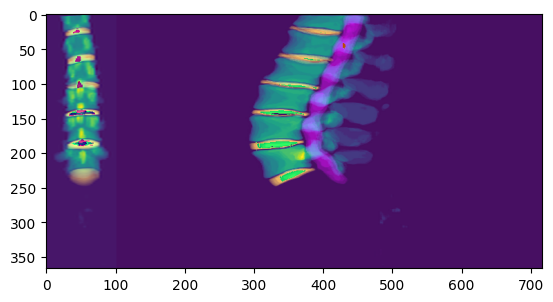

(3, 32, 615, 367)
Bruhhhh
(3, 32, 615, 367)
(32, 615, 367)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC85_t1.nii.gz
Inference on case 85_t1.nii.gz
(320, 53, 3)
(320, 320, 3)


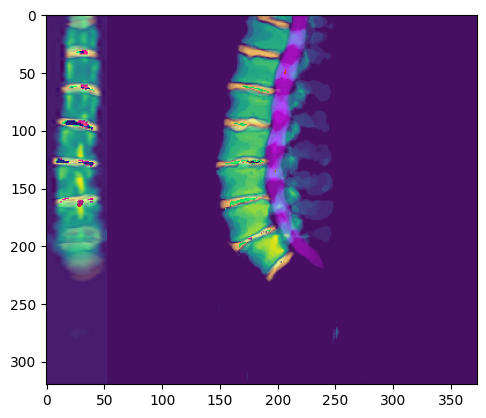

(3, 15, 320, 320)
Bruhhhh
(3, 15, 320, 320)
(15, 320, 320)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC85_t2.nii.gz
Inference on case 85_t2.nii.gz
(384, 64, 3)
(384, 384, 3)


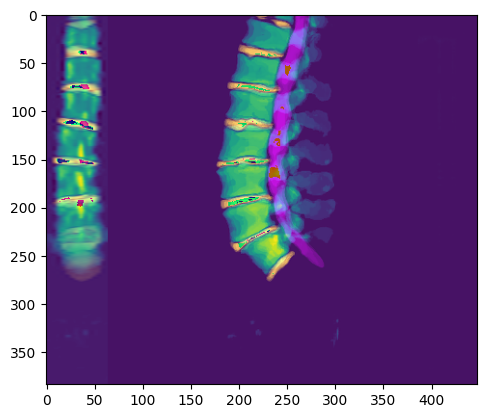

(3, 15, 384, 384)
Bruhhhh
(3, 15, 384, 384)
(15, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC86_t1.nii.gz
Inference on case 86_t1.nii.gz
(424, 75, 3)
(424, 448, 3)


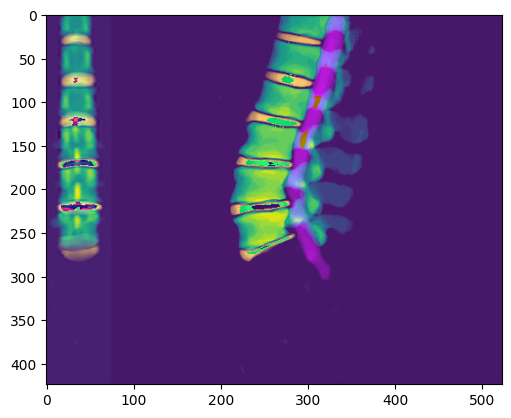

(3, 25, 448, 424)
Bruhhhh
(3, 25, 448, 424)
(25, 448, 424)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC86_t2.nii.gz
Inference on case 86_t2.nii.gz
(424, 75, 3)
(424, 448, 3)


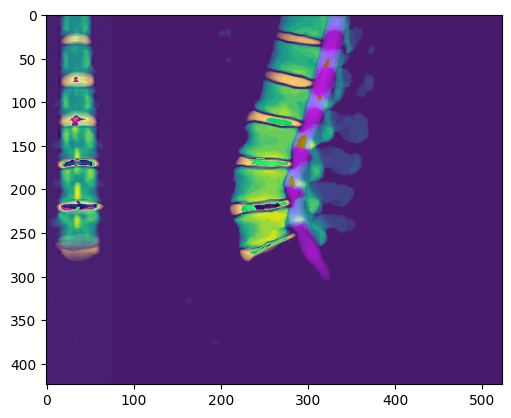

(3, 25, 448, 424)
Bruhhhh
(3, 25, 448, 424)
(25, 448, 424)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC87_t1.nii.gz
Inference on case 87_t1.nii.gz
(383, 75, 3)
(383, 448, 3)


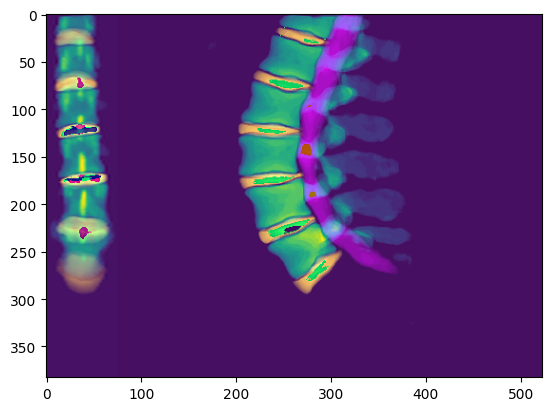

(3, 27, 448, 383)
Bruhhhh
(3, 27, 448, 383)
(27, 448, 383)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC87_t2.nii.gz
Inference on case 87_t2.nii.gz
(383, 75, 3)
(383, 448, 3)


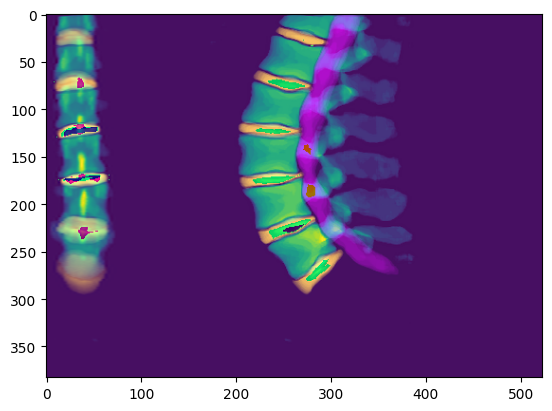

(3, 27, 448, 383)
Bruhhhh
(3, 27, 448, 383)
(27, 448, 383)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC88_t1.nii.gz
Inference on case 88_t1.nii.gz
(418, 53, 3)
(418, 320, 3)


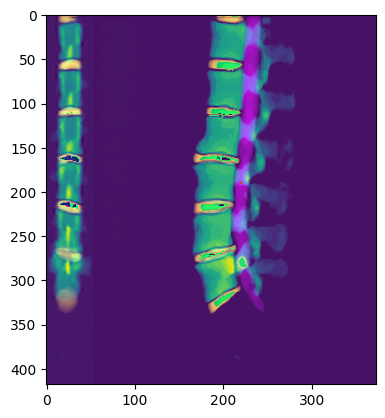

(3, 18, 320, 418)
Bruhhhh
(3, 18, 320, 418)
(18, 320, 418)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC88_t2.nii.gz
Inference on case 88_t2.nii.gz
(533, 64, 3)
(533, 384, 3)


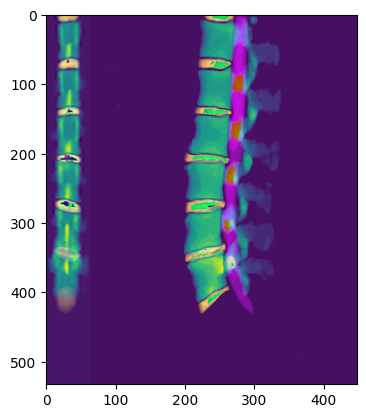

(3, 18, 384, 533)
Bruhhhh
(3, 18, 384, 533)
(18, 384, 533)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC89_t2.nii.gz
Inference on case 89_t2.nii.gz
(384, 64, 3)
(384, 384, 3)


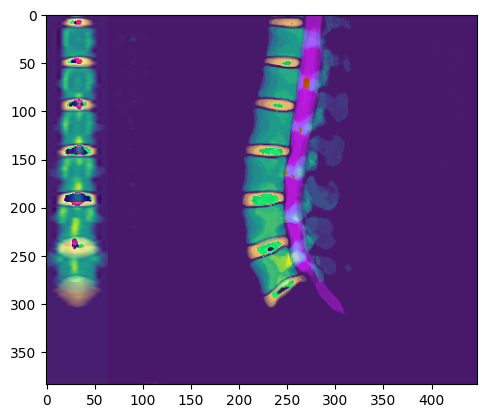

(3, 14, 384, 384)
Bruhhhh
(3, 14, 384, 384)
(14, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC9_t1.nii.gz
Inference on case 9_t1.nii.gz
(464, 53, 3)
(464, 320, 3)


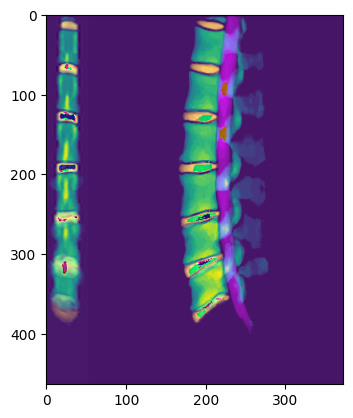

(3, 19, 320, 464)
Bruhhhh
(3, 19, 320, 464)
(19, 320, 464)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC9_t2.nii.gz
Inference on case 9_t2.nii.gz
(610, 64, 3)
(610, 384, 3)


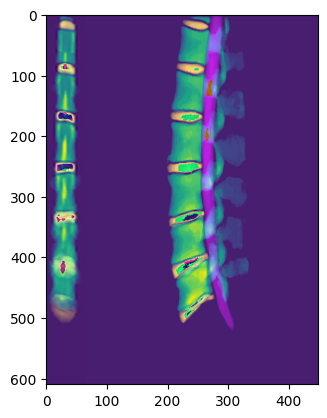

(3, 19, 384, 610)
Bruhhhh
(3, 19, 384, 610)
(19, 384, 610)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC90_t1.nii.gz
Inference on case 90_t1.nii.gz
(254, 53, 3)
(254, 320, 3)


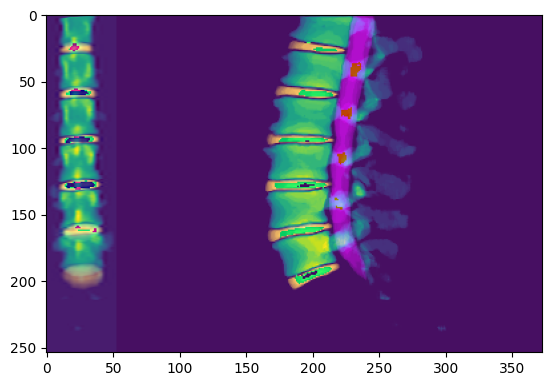

(3, 19, 320, 254)
Bruhhhh
(3, 19, 320, 254)
(19, 320, 254)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC90_t2.nii.gz
Inference on case 90_t2.nii.gz
(293, 64, 3)
(293, 384, 3)


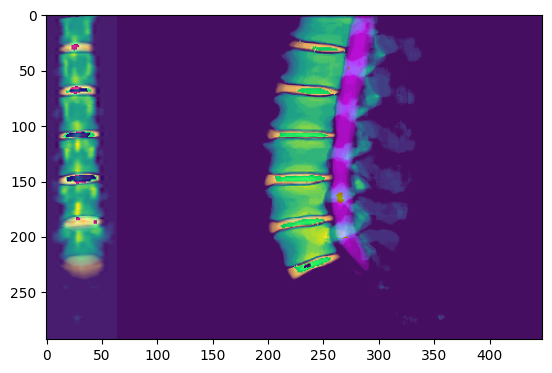

(3, 19, 384, 293)
Bruhhhh
(3, 19, 384, 293)
(19, 384, 293)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC91_t2.nii.gz
Inference on case 91_t2.nii.gz
(384, 64, 3)
(384, 384, 3)


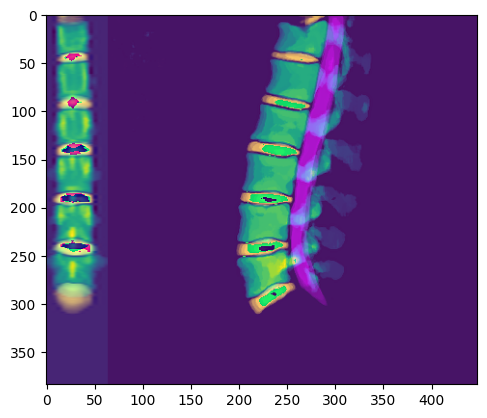

(3, 15, 384, 384)
Bruhhhh
(3, 15, 384, 384)
(15, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC93_t1.nii.gz
Inference on case 93_t1.nii.gz
(292, 53, 3)
(292, 320, 3)


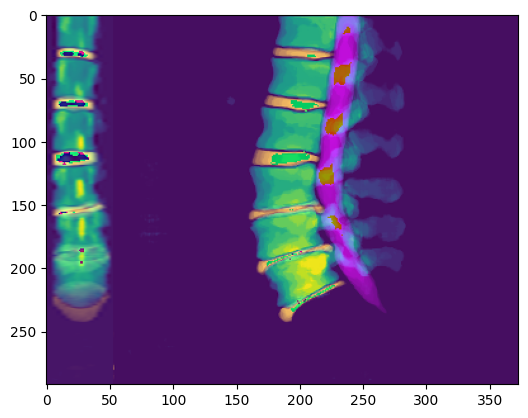

(3, 16, 320, 292)
Bruhhhh
(3, 16, 320, 292)
(16, 320, 292)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC93_t2.nii.gz
Inference on case 93_t2.nii.gz
(390, 64, 3)
(390, 384, 3)


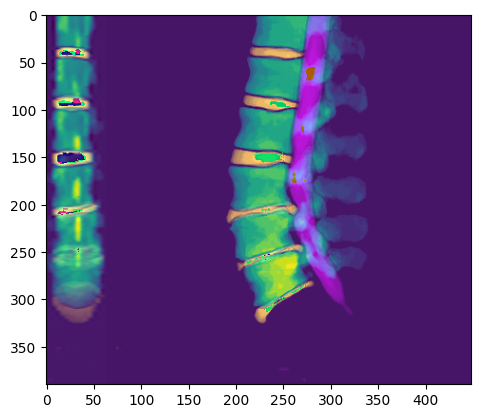

(3, 16, 384, 390)
Bruhhhh
(3, 16, 384, 390)
(16, 384, 390)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC94_t1.nii.gz
Inference on case 94_t1.nii.gz
(512, 75, 3)
(512, 448, 3)


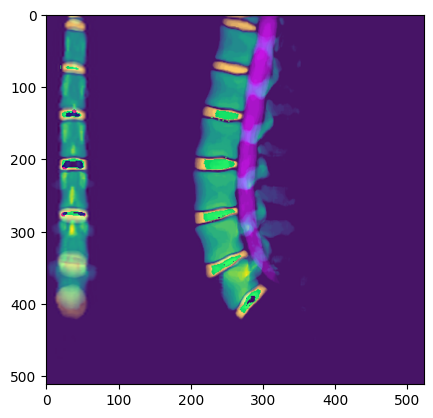

(3, 26, 448, 512)
Bruhhhh
(3, 26, 448, 512)
(26, 448, 512)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC94_t2.nii.gz
Inference on case 94_t2.nii.gz
(512, 75, 3)
(512, 448, 3)


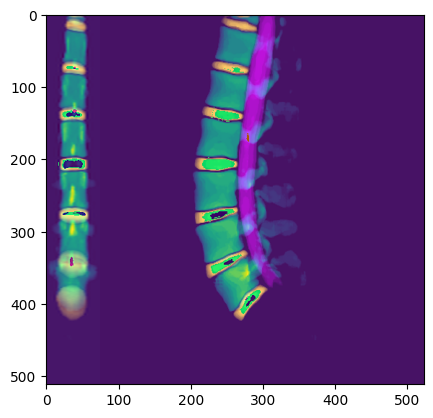

(3, 26, 448, 512)
Bruhhhh
(3, 26, 448, 512)
(26, 448, 512)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC95_t1.nii.gz
Inference on case 95_t1.nii.gz
(448, 75, 3)
(448, 448, 3)


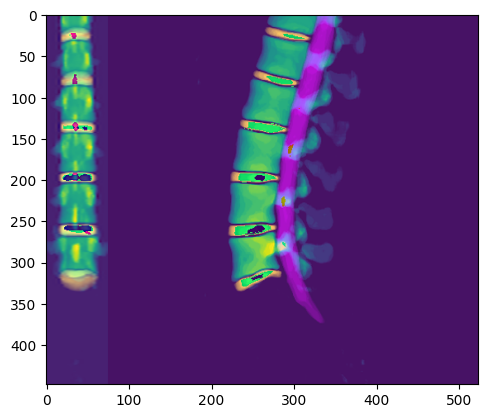

(3, 24, 448, 448)
Bruhhhh
(3, 24, 448, 448)
(24, 448, 448)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC95_t2.nii.gz
Inference on case 95_t2.nii.gz
(448, 75, 3)
(448, 448, 3)


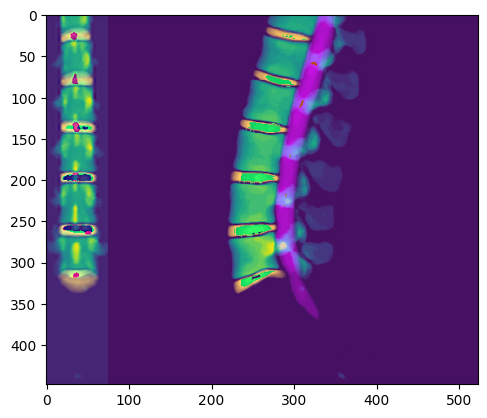

(3, 24, 448, 448)
Bruhhhh
(3, 24, 448, 448)
(24, 448, 448)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC96_t1.nii.gz
Inference on case 96_t1.nii.gz
(384, 64, 3)
(384, 384, 3)


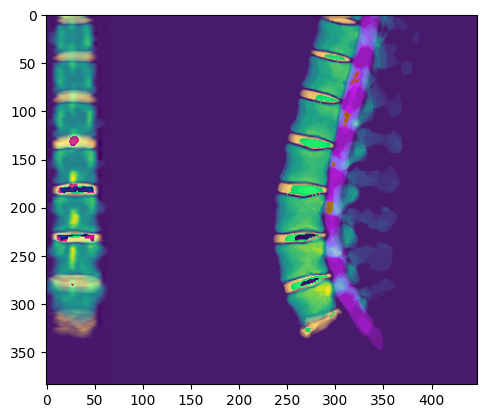

(3, 15, 384, 384)
Bruhhhh
(3, 15, 384, 384)
(15, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC96_t2.nii.gz
Inference on case 96_t2.nii.gz
(384, 64, 3)
(384, 384, 3)


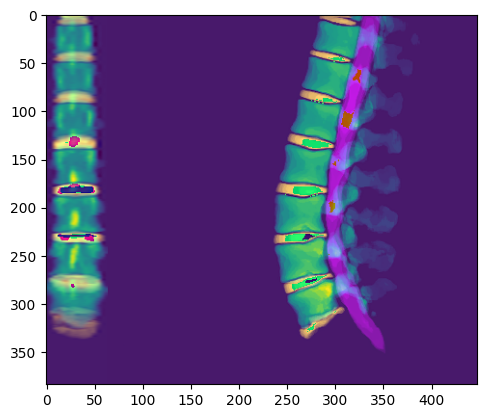

(3, 15, 384, 384)
Bruhhhh
(3, 15, 384, 384)
(15, 384, 384)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC97_t2.nii.gz
Inference on case 97_t2.nii.gz
(326, 64, 3)
(326, 384, 3)


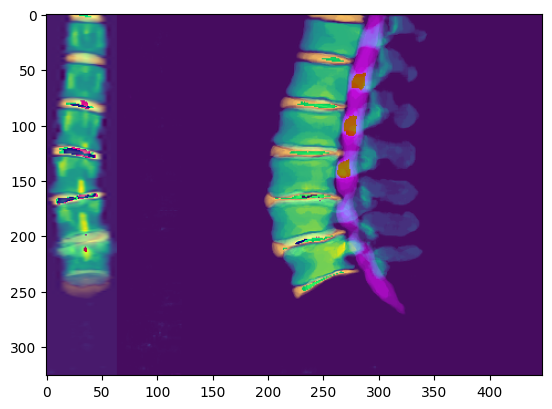

(3, 17, 384, 326)
Bruhhhh
(3, 17, 384, 326)
(17, 384, 326)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC98_t1.nii.gz
Inference on case 98_t1.nii.gz
(512, 85, 3)
(512, 512, 3)


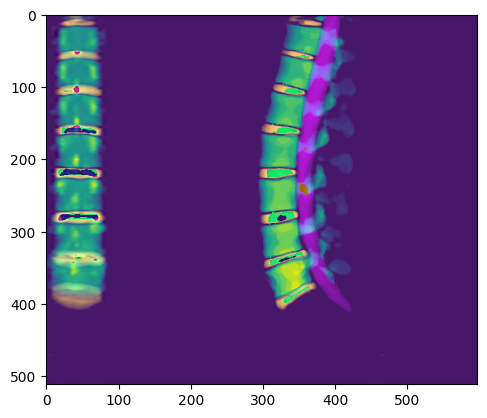

(3, 17, 512, 512)
Bruhhhh
(3, 17, 512, 512)
(17, 512, 512)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC98_t2.nii.gz
Inference on case 98_t2.nii.gz
(512, 85, 3)
(512, 512, 3)


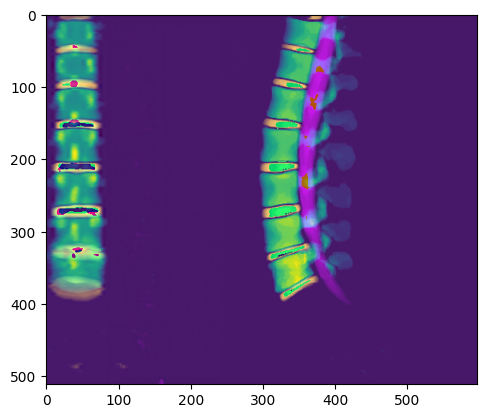

(3, 17, 512, 512)
Bruhhhh
(3, 17, 512, 512)
(17, 512, 512)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC98_t2_SPACE.nii.gz
Inference on case 98_t2_SPACE.nii.gz
(640, 85, 3)
(640, 512, 3)


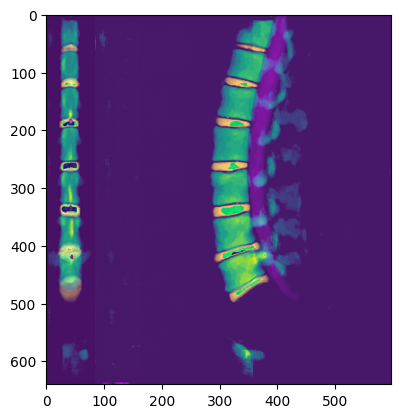

(3, 120, 512, 640)
Bruhhhh
(3, 120, 512, 640)
(120, 512, 640)
dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])
torch.Size([1, 2, 32, 420, 420])
CCCCCCCC99_t2.nii.gz
Inference on case 99_t2.nii.gz
(551, 185, 3)
(551, 1111, 3)


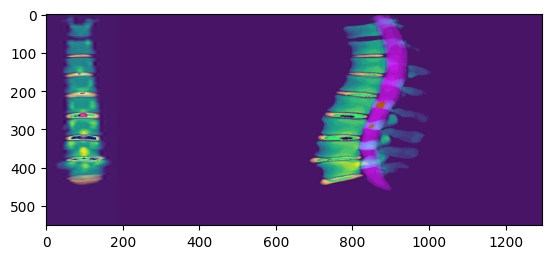

(3, 23, 1111, 551)
Bruhhhh
(3, 23, 1111, 551)
(23, 1111, 551)
Finished inference!


In [1]:
from matplotlib import pyplot as plt
import rootutils
rootutils.setup_root("/work/hpc/spine-segmentation/notebooks/logger_wandb.ipynb", indicator=".project-root", pythonpath=True)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

from functools import partial

import nibabel as nib
import numpy as np

from lightning import LightningModule
import torch
from torch.utils.data import DataLoader, Dataset
# from src.models.brats21_module import Brats21LitModule
from src.models.spider_semantic_module import SpiderLitModule
from monai.inferers import sliding_window_inference

from monai.transforms.utils import allow_missing_keys_mode
from scipy.ndimage import zoom
from matplotlib import cm
from matplotlib.colors import Normalize

class Inferer(object):
    def __init__(
        self,
        exp_name: str,
        checkpoint_path: str,
        data_name: str,
        data_loader: DataLoader,
        net: torch.nn.Module,
        model_inferer: sliding_window_inference,
        device
    ):
        self.output_directory = "/work/hpc/spine-segmentation/outputs/" + exp_name ##"./outputs/" + exp_name
        print(os.getcwd())
        if not os.path.exists(self.output_directory):
            os.makedirs(self.output_directory)
            
        self.data_name = data_name
        self.data_loader = data_loader
        net.to(device)
        self.net = net
        model = SpiderLitModule.load_from_checkpoint(checkpoint_path=checkpoint_path)
        self.model_inferer = partial(model_inferer, predictor=model)
      
    def feed(self):
        with torch.no_grad():
            for i, batch in enumerate(self.data_loader):
                image = batch["image"].cuda()
                label = batch["label"].cuda()
                print(batch.keys())
                print(image.size())
                affine = batch["image_meta_dict"]["original_affine"][0].numpy()
                original_size = batch["image_meta_dict"]["spatial_shape"][0]

                img_name = batch["image_meta_dict"]["filename_or_obj"][0].split("/")[-1]
                print("CCCCCCCC" + img_name)
                print("Inference on case {}".format(img_name))
                prob = torch.sigmoid(self.model_inferer(image)) ## this or that
                # prob = torch.sigmoid(self.net(image)) ## that
                seg = prob[0].detach().cpu().numpy()
                self.logger(seg)
                seg = zoom(seg, (1, float(original_size[0])/seg.shape[1], float(original_size[1])/seg.shape[2], float(original_size[2])/seg.shape[3]))
                print(seg.shape)
                seg = (seg > 0.5).astype(np.int8)
                print("Bruhhhh")
                print(seg.shape)
                seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
                seg_out[seg[1] == 1] = 2
                seg_out[seg[0] == 1] = 1
                seg_out[seg[2] == 1] = 4
                # resize_op = self.data_loader.dataset.transform
                # with allow_missing_keys_mode:
                #     print(resize_op.inverse({"label": seg_out}))

                print(seg_out.shape)
                # seg_out = np.resize(seg_out, original_size.numpy())
                nib.save(nib.Nifti1Image(seg_out.astype(np.uint8), affine), os.path.join(self.output_directory, img_name))
            print("Finished inference!")
        
        # for i, batch in enumerate(self.data_loader):
        #     print(batch['image'].size())
        #     if (i == 0):
        #         print(batch['image'][0])

    def merge_image(self, vertebral_img, disk_img, canal_img = 0):
        if isinstance(canal_img, int) == False:
            canal_img = np.stack([canal_img, np.zeros(canal_img.shape), canal_img], axis = -1)
            canal_img = canal_img / canal_img.max() / 2

        norm_vertebral = Normalize(vmin=vertebral_img.min(), vmax=vertebral_img.max())

        disk_img = np.stack([disk_img, disk_img, np.zeros(disk_img.shape)], axis = -1)
        disk_img = disk_img / disk_img.max()

        vertebral_img = cm.viridis(norm_vertebral(vertebral_img))[:, :, :3] + disk_img + canal_img

        return vertebral_img

    def logger(self, predict_seg):
        coronal_view = torch.sum(predict_seg, dim=2).permute(0, 2, 1)
        sagittal_view = torch.sum(predict_seg, dim=1)

        image1 = self.merge_image(coronal_view[0], coronal_view[2])
        image2 = self.merge_image(sagittal_view[0], sagittal_view[2], sagittal_view[1])
        image2 = np.rot90(image2, 1)

        print(image1.shape)
        print(image2.shape)

        image_all = np.concatenate((image1, image2), axis = 1)

        plt.imshow(image_all)
        plt.show()
        

            
import hydra
from omegaconf import OmegaConf, DictConfig

config_name = "infer_spider"

config_path = os.path.join(os.environ["PROJECT_ROOT"], "configs/app")

cfg = OmegaConf.load(os.path.join(config_path, config_name + ".yaml"))

# print(OmegaConf.to_yaml(cfg))
inferer: Inferer = hydra.utils.instantiate(cfg)
print(inferer)
# print(type(inferer))
inferer.feed()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
The figure layout has changed to tight


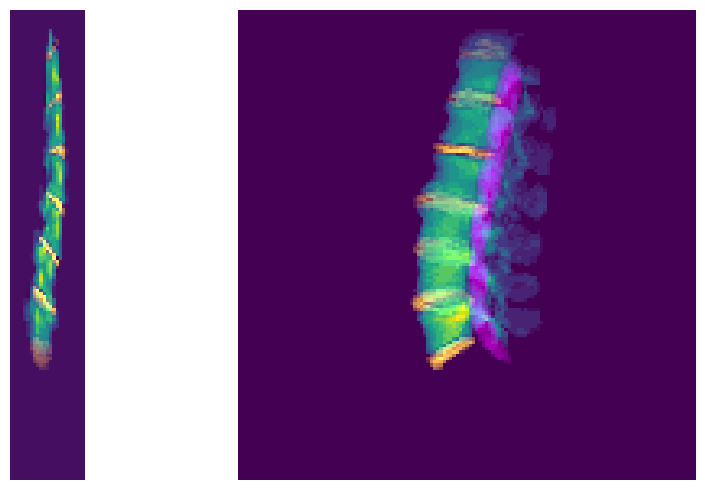

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

def merge_image(vertebral_img, disk_img, canal_img = 0):
    if isinstance(canal_img, int) == False:
        canal_img = np.stack([canal_img, np.zeros(canal_img.shape), canal_img], axis = -1)
        canal_img = canal_img / canal_img.max() / 2

    norm_vertebral = Normalize(vmin=vertebral_img.min(), vmax=vertebral_img.max())

    disk_img = np.stack([disk_img, disk_img, np.zeros(disk_img.shape)], axis = -1)
    disk_img = disk_img / disk_img.max()

    vertebral_img = cm.viridis(norm_vertebral(vertebral_img))[:, :, :3] + disk_img + canal_img

    return vertebral_img


fig, axs = plt.subplots(1, 2, layout = "constrained", figsize=(10, 5))

# axs[0].imshow(coronal_view[0])
# axs[0].axis('off')

axs[0].imshow(merge_image(coronal_view[0], coronal_view[2]))
axs[0].axis('off')

axs[1].imshow(np.rot90(merge_image(sagittal_view[0], sagittal_view[2], sagittal_view[1]), 1))
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [46]:
cv2.imwrite("/work/hpc/spine-segmentation/notebooks/test.png", coronal_view[2]) 

True

In [86]:
a = np.array([[0 , 1], [2, 3]])

def test(b):
    b[1] = 60

test(a[0])

print(a[0])

[ 0 60]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(420, 84, 3)
(420, 420, 3)


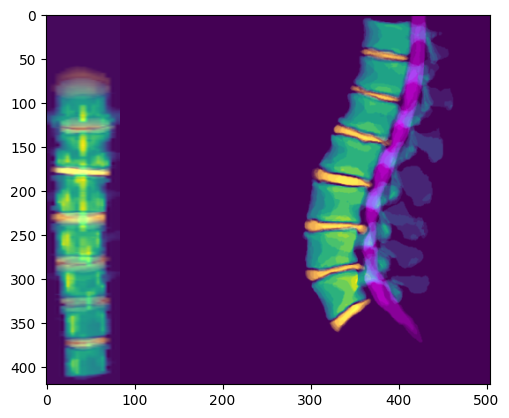

In [61]:
image1 = merge_image(coronal_view[0], coronal_view[2])
image2 = merge_image(sagittal_view[0], sagittal_view[2], sagittal_view[1])
image2 = np.rot90(image2, 1)
print(image1.shape)
print(image2.shape)

image_all = np.concatenate((image1, image2), axis = 1)

plt.imshow(image_all)

torch.Size([3, 32, 420, 420])


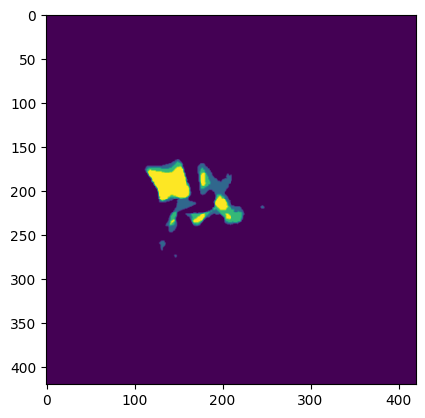

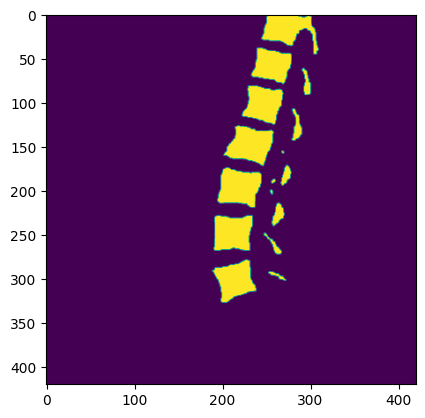

In [43]:
from monai.data.utils import list_data_collate
dataloader = DataLoader(dataset=transformed, 
            batch_size=1,
            num_workers=4,
            pin_memory=False,
            shuffle=False,
            collate_fn = list_data_collate)

batch = next(iter(dataloader))

print(batch["label"][0].shape)

plt.imshow(batch["label"][0][0][10])

for i, batch in enumerate(dataloader):
    plt.imshow(batch["label"][0][0][10])
    plt.show()
        